## Analysis of a single dataset 

In [ ]:
library(Seurat)
library(CellChat)
library(patchwork)

load('~/DATA/code/myCode/scRNA.rdata'))
col<-c('Hepatocyte'="#1F78B4",'Endothelial'="#B2DF8A",'B'="#E31A1C",
       'Myeloid'="#FDBF6F",'T/NK'="#6A3D9A",'Fibroblast'="#A6761D")
DimPlot(scRNA, reduction = "umap",group.by = "celltype",label = T,cols = col)

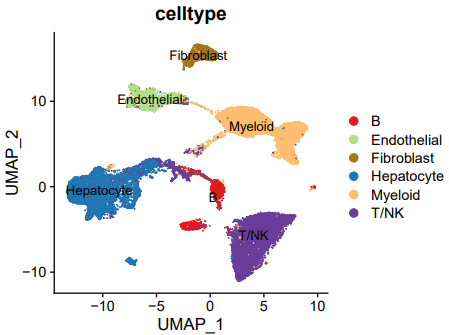

In [ ]:
##提取Hepatocyte与Myeloid进行通讯分析
data<-subset(scRNA, celltype %in% c( 'Hepatocyte','Myeloid' ))
##创建Seurat对象
data<-CreateSeuratObject(counts = data@assays$RNA@counts,
                            meta.data = data@meta.data)
##进行继续降维聚类分群
#筛选高可变基因，并进行数据降维
data <- NormalizeData(data) %>% 
  FindVariableFeatures(selection.method = "vst",nfeatures = 2000) %>% 
  ScaleData() %>% 
  RunPCA(npcs = 30, verbose = T)

library(harmony)
##harmony去批次
data <- RunHarmony(data,reduction = "pca",group.by.vars = "orig.ident",reduction.save = "harmony")
#UMAP非线性降维
data <- RunUMAP(data, reduction = "harmony", dims = 1:20,reduction.name = "umap")
#查看去批次效果
DimPlot(data, reduction = "umap",group.by = "orig.ident")
##识别cluster
data <- FindNeighbors(data, reduction = "harmony", dims = 1:20) %>% 
  FindClusters(resolution = 0.4)  

DimPlot(data,reduction = "umap",label=T)

In [ ]:
library(SingleR)
#载入参考数据集
ref_use <- load("/home/zhaojingwei/R/data/HumanPrimaryCellAtlas_hpca.se_human.RData") 

pred <- SingleR(test=as.matrix(data@assays$RNA@data),       #输入表达矩阵
                ref=hpca.se,                                #参考数据
                labels=hpca.se$label.main,                  #标签列
                clusters = data$seurat_clusters) 

celltype = data.frame(ClusterID=rownames(pred), celltype=pred$labels, stringsAsFactors = F)
data@meta.data$singleR=celltype[match((data@meta.data$seurat_clusters),celltype$ClusterID),'celltype']

cols = c('DC'="#7fc97f",'Macrophage'="#beaed4",'Monocyte'="#fdc086",'Hepatocytes'="#386cb0")
DimPlot(data,group.by = 'singleR',cols = cols,split.by = 'Group')

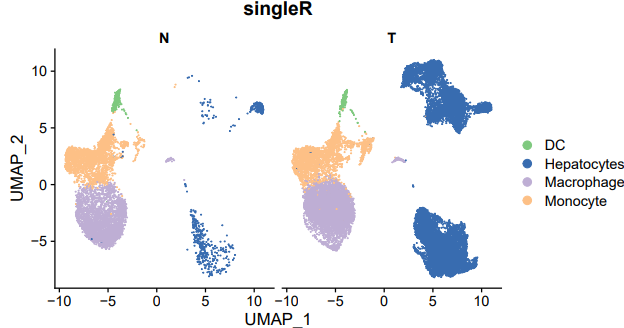

## 分组依次做Cellchat

In [ ]:
##Tumor组
Tumor<-subset(data, Group %in% 'T')
cellChat <- createCellChat(object = Tumor, 
                           group.by = "singleR", 
                           assay = "RNA")
CellChatDB <- CellChatDB.human # use CellChatDB.mouse if running on mouse data
showDatabaseCategory(CellChatDB)

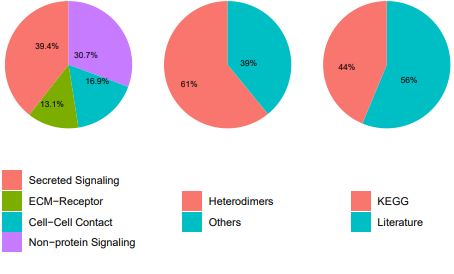

In [ ]:
# use Secreted Signaling
CellChatDB.use <- subsetDB(CellChatDB, search = "Secreted Signaling", key = "annotation")
cellchat@DB <- CellChatDB.use

#预处理用于细胞间通信分析的表达数据
cellchat <- subsetData(cellchat) # This step is necessary
future::plan("multisession", workers = 4)
##识别过表达基因
cellchat <- identifyOverExpressedGenes(cellchat)
##识别过表达配体受体对
cellchat <- identifyOverExpressedInteractions(cellchat)


##推断 cell-cell communication network
cellchat <- computeCommunProb(cellchat, raw.use = TRUE, population.size = TRUE) 
cellchat <- filterCommunication(cellchat, min.cells = 10)
##保存全部结果
df.net <- subsetCommunication(cellchat)
write.csv(df.net, "cell-cell_communications.all.csv")
##从信号通路水平推断细胞间通讯
cellchat <- computeCommunProbPathway(cellchat)
##计算整合的细胞类型之间通信结果
cellchat <- aggregateNet(cellchat)


##visualize 
groupSize <- as.numeric(table(cellchat@idents))
par(mfrow = c(1,2), xpd=TRUE)
netVisual_circle(cellchat@net$count, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Number of interactions")
netVisual_circle(cellchat@net$weight, vertex.weight = groupSize, weight.scale = T, label.edge= F, 
                 title.name = "Interaction weights/strength")

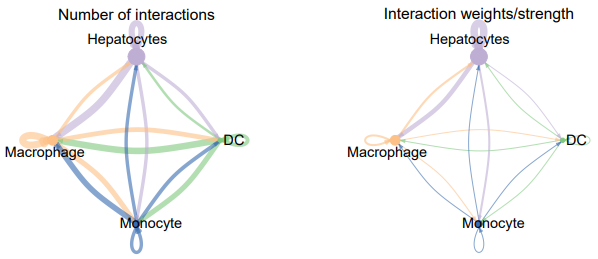

In [ ]:
##分别展示
mat <- cellchat@net$weight
par(mfrow = c(2,2), xpd=TRUE)
for (i in 1:nrow(mat)) {
  mat2 <- matrix(0, nrow = nrow(mat), ncol = ncol(mat), dimnames = dimnames(mat))
  mat2[i, ] <- mat[i, ]
  netVisual_circle(mat2, vertex.weight = groupSize, weight.scale = T, 
                   edge.weight.max = max(mat), 
                   title.name = rownames(mat)[i])
}

In [ ]:
##显著通路
cellchat@netP$pathways

pathways.show <- c("SPP1")  

levels(cellchat@idents)   

vertex.receiver = seq(1:2) # a numeric vector. 
netVisual_aggregate(cellchat, signaling = pathways.show,  vertex.receiver = vertex.receiver,layout = "hierarchy")

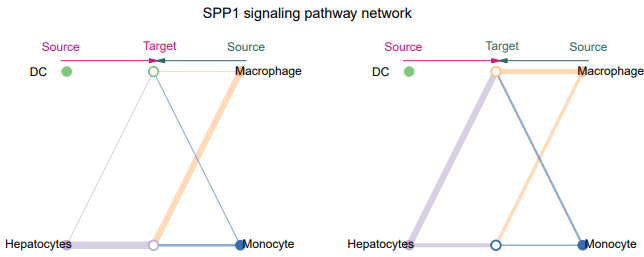

In [ ]:
# Circle plot
library(ggpubr)

par(mfrow=c(1,1))
p1<-netVisual_aggregate(cellchat, signaling = pathways.show, layout = "circle",color.use = cols)
p2<-netVisual_aggregate(cellchat, signaling = pathways.show, layout = "chord",color.use = cols)
ggarrange(p1,p2)

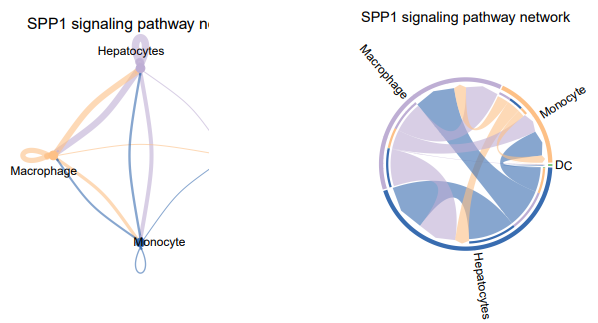

In [ ]:
# Heatmap
par(mfrow=c(1,1))
netVisual_heatmap(cellchat, signaling = pathways.show, color.heatmap ="Reds",
                  color.use =c("#7fc97f","#beaed4","#fdc086","#386cb0"))

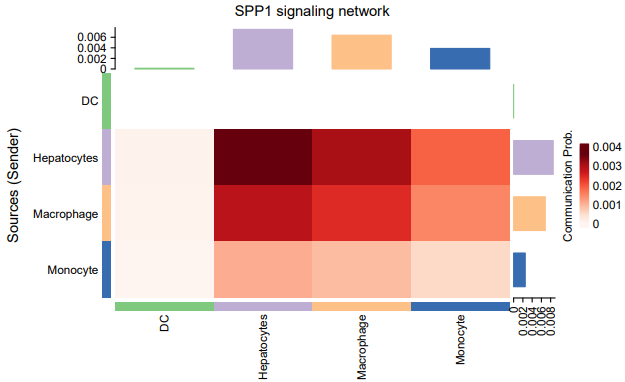

In [ ]:
##计算每个配体-受体对的贡献
netAnalysis_contribution(cellchat, signaling = pathways.show)

##配体-受体对Circle plot
pairLR.CXCL <- extractEnrichedLR(cellchat, signaling = pathways.show, geneLR.return = FALSE)
LR.show <- pairLR.CXCL[1,] # show one ligand-receptor pair
netVisual_individual(cellchat, signaling = pathways.show, pairLR.use = LR.show, layout = "circle")

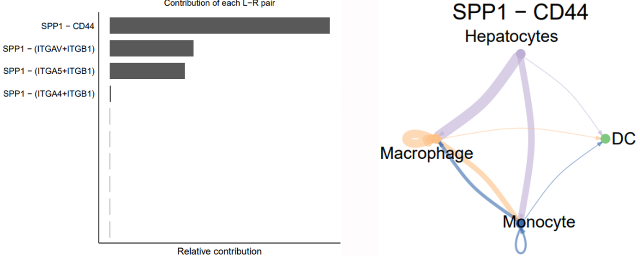

In [ ]:
##L-R pairs Bubble plot
levels(cellchat@idents)
p3<-netVisual_bubble(cellchat, sources.use = c(1,3,4), targets.use = c(2), remove.isolate = FALSE)
p4<-netVisual_bubble(cellchat,signaling = c("MIF","CXCL"), remove.isolate = FALSE)
ggarrange(p3,p4)

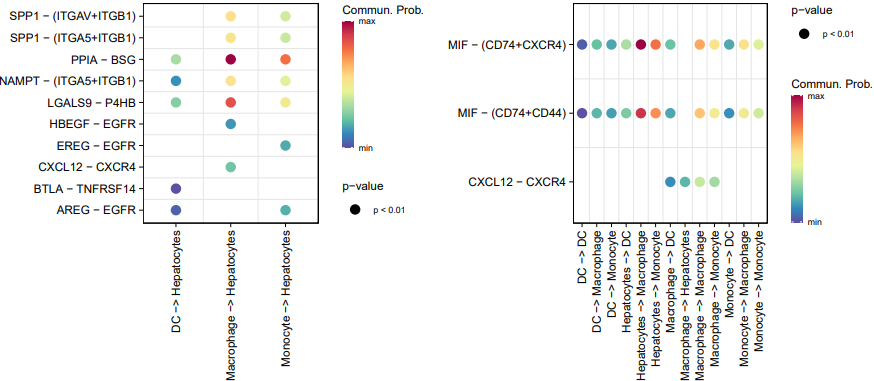

In [ ]:
##Chord diagram
##show interactions received by Hepatocyte with certain signaling pathways
netVisual_chord_gene(cellchat, sources.use = c(1,3,4), 
                     signaling = c("MIF","MIF","CypA","SPP1","CXCL"),
                     targets.use = c(2), lab.cex = 0.5,
                     legend.pos.y = 30,color.use = cols)

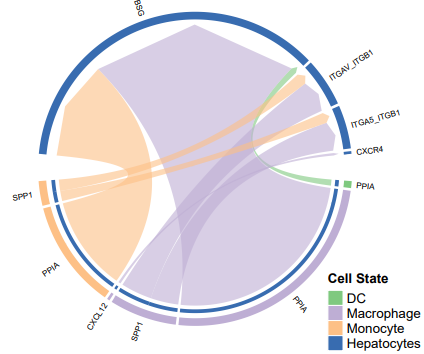

In [ ]:
##Plot the signaling gene expression
plotGeneExpression(cellchat, signaling = "SPP1", enriched.only = TRUE, type = "violin",color.use = cols)

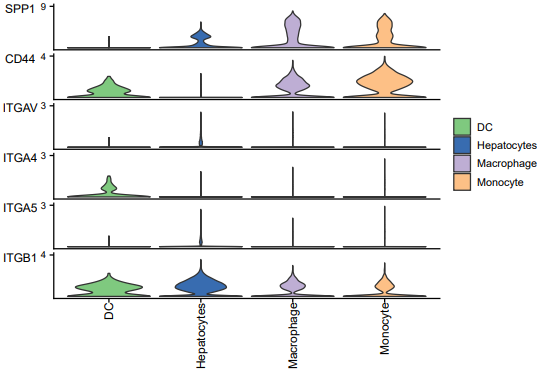

In [ ]:
##Systems analysis of cell-cell communication network
# Compute the network centrality scores
cellchat <- netAnalysis_computeCentrality(cellchat, slot.name = "netP")
netAnalysis_signalingRole_network(cellchat, signaling = pathways.show, 
                                  width = 8, height = 2.5, font.size = 10,color.use = cols)

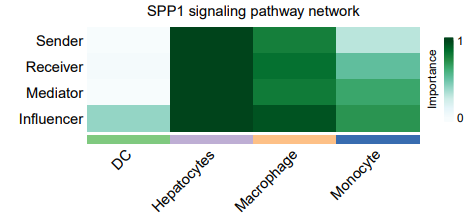

In [ ]:
saveRDS(cellchat,file = '~/DATA/code/myCode/cellchat/cellchat_T.rds')
saveRDS(cellchat,file = '~/DATA/code/myCode/cellchat/cellchat_N.rds')

## Comparison analysis of multiple datasets

In [ ]:
rm(list = ls())

cols = c('DC'="#7fc97f",'Macrophage'="#beaed4",'Monocyte'="#fdc086",'Hepatocytes'="#386cb0")
cellchat_N <- readRDS("~/DATA/code/myCode/cellchat/cellchat_N.rds")
cellchat_T <- readRDS("~/DATA/code/myCode/cellchat/cellchat_T.rds")
object.list <- list(N = cellchat_N, T = cellchat_T)
cellchat <- mergeCellChat(object.list, add.names = names(object.list))

##Compare the total number 
gg1 <- compareInteractions(cellchat, show.legend = F, group = c(1,2),color.use = c('#386cb0','#fdc086'))
gg2 <- compareInteractions(cellchat, show.legend = F, group = c(1,2), measure = "weight",color.use =  c('#386cb0','#fdc086'))
gg1 + gg2

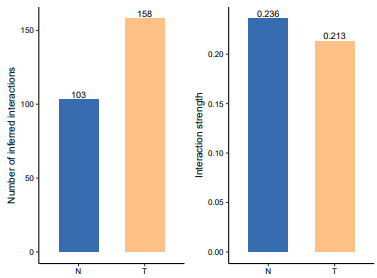

In [ ]:
## Circle plot showing differential number of interactions or interaction strength
gg1 <- compareInteractions(cellchat, show.legend = F, group = c(1,2),color.use = c('#386cb0','#fdc086'))
gg2 <- compareInteractions(cellchat, show.legend = F, group = c(1,2), measure = "weight",color.use =  c('#386cb0','#fdc086'))
gg1 + gg2

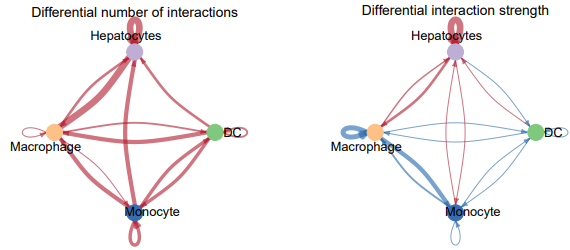

In [1]:
##Heatmap
gg1 <- netVisual_heatmap(cellchat, 
                         color.heatmap = c('white','#EE3B3B','#d01b2a'),
                         color.use =cols)
gg2 <- netVisual_heatmap(cellchat, measure = "weight", 
                         color.heatmap = c('white','#EE3B3B','#d01b2a'),
                         color.use = cols)
gg1 + gg2

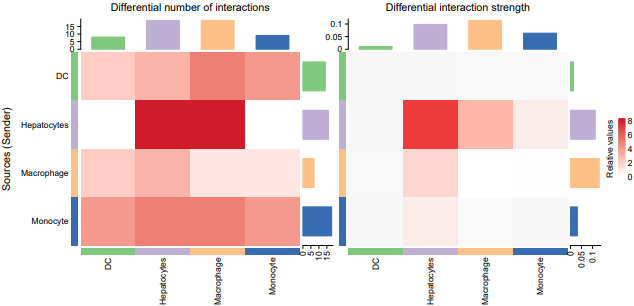

In [ ]:
##Circle plot showing the number of interactions or interaction strength
weight.max <- getMaxWeight(object.list, attribute = c("idents","count"))
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_circle(object.list[[i]]@net$count, 
                   weight.scale = T,
                   color.use = cols, 
                   label.edge= F, 
                   edge.weight.max = weight.max[2], 
                   edge.width.max = 12, 
                   title.name = paste0("Number of interactions - ", 
                   names(object.list)[i]))
}

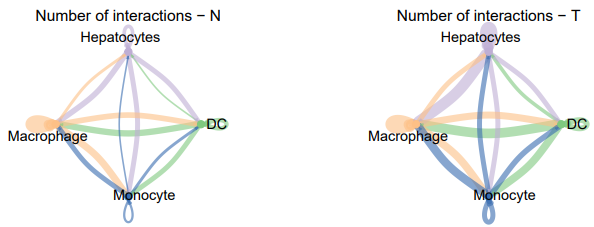

In [ ]:
##Circle plot showing the differential number
weight.max <- getMaxWeight(object.list, slot.name = c("idents", "net", "net"), 
                           attribute = c("idents","count"))

par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_circle(object.list[[i]]@net$count, weight.scale = T, 
                   color.use = cols,label.edge= T, 
                   edge.weight.max = weight.max[3], 
                   edge.width.max = 12, 
                   title.name = paste0("Number of interactions - ", names(object.list)[i]))
}

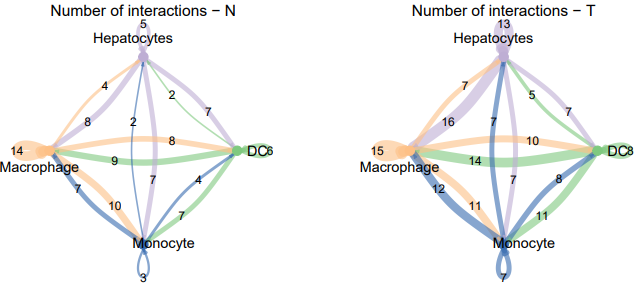

In [ ]:
##Compare the major sources and targets in a 2D space
num.link <- sapply(object.list, function(x) {rowSums(x@net$count) + colSums(x@net$count)-diag(x@net$count)})
weight.MinMax <- c(min(num.link), max(num.link)) # control the dot size in the different datasets
gg <- list()
for (i in 1:length(object.list)) {
  gg[[i]] <- netAnalysis_signalingRole_scatter(object.list[[i]], title = names(object.list)[i], color.use = cols,weight.MinMax = weight.MinMax)
}

patchwork::wrap_plots(plots = gg)
#与Normal相比，恶性肝细胞成为Tumor组的主要来源和靶标之一。

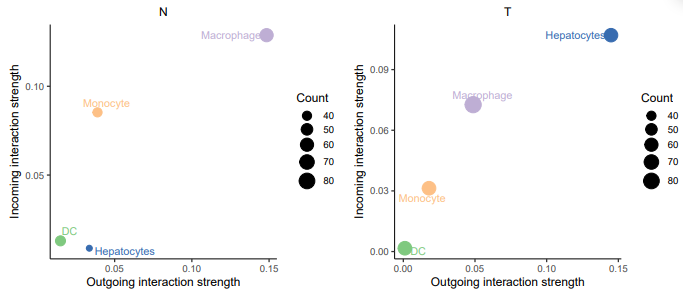

In [ ]:
##Compare the overall information flow 
gg1 <- rankNet(cellchat, mode = "comparison", measure = "weight",
               sources.use = NULL, targets.use = NULL, stacked = T, 
               do.stat = TRUE,color.use =  c('#386cb0','#fdc086'))
gg2 <- rankNet(cellchat, mode = "comparison", measure = "weight",
               sources.use = NULL, targets.use = NULL, stacked = F, 
               do.stat = TRUE,color.use =  c('#386cb0','#fdc086'))

gg1 + gg2

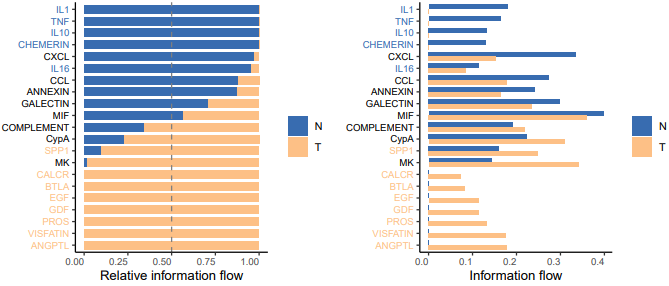

In [ ]:
##comparing the communication probabities
netVisual_bubble(cellchat, sources.use =  c(1,3,4), targets.use = c(2),  
                 comparison = c(1, 2), angle.x = 45,
                 color.text =c('#386cb0','#fdc086'))

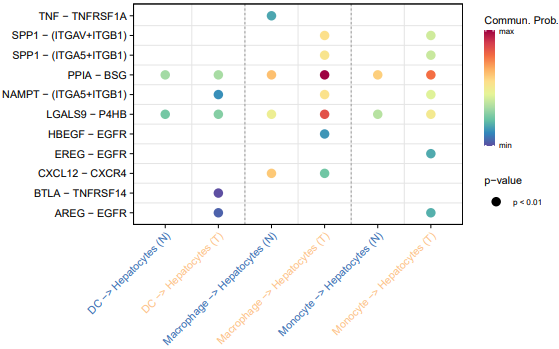

In [ ]:
##Visually compare cell-cell communication
pathways.show <- c("SPP1") 
weight.max <- getMaxWeight(object.list, slot.name = c("netP"), attribute = pathways.show) # control the edge weights across different datasets
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_aggregate(object.list[[i]], signaling = pathways.show, color.use =cols,layout = "circle", edge.weight.max = weight.max[1], edge.width.max = 10, signaling.name = paste(pathways.show, names(object.list)[i]))
}

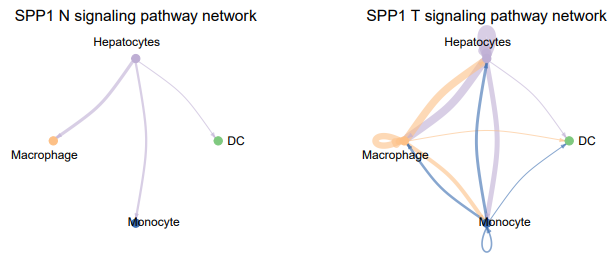

In [ ]:
##Heatmap
pathways.show <- c("SPP1")
par(mfrow = c(1,2), xpd=TRUE)
ht <- list()
for (i in 1:length(object.list)) {
  ht[[i]] <- netVisual_heatmap(object.list[[i]], 
                               signaling = pathways.show, 
                               color.use =cols,color.heatmap = "Reds",
                               title.name = paste(pathways.show, "signaling ",names(object.list)[i]))
}
ComplexHeatmap::draw(ht[[1]] + ht[[2]], ht_gap = unit(0.5, "cm"))

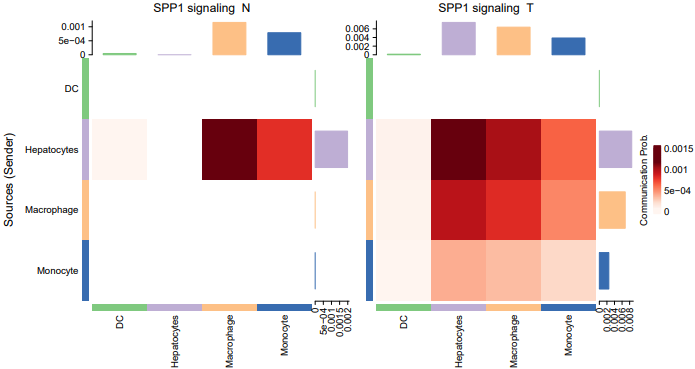

In [ ]:
##Chord
par(mfrow = c(1,2), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_aggregate(object.list[[i]], 
                      signaling = pathways.show,
                      color.use =cols,layout = "chord",
                      signaling.name = paste(pathways.show, names(object.list)[i]))
}

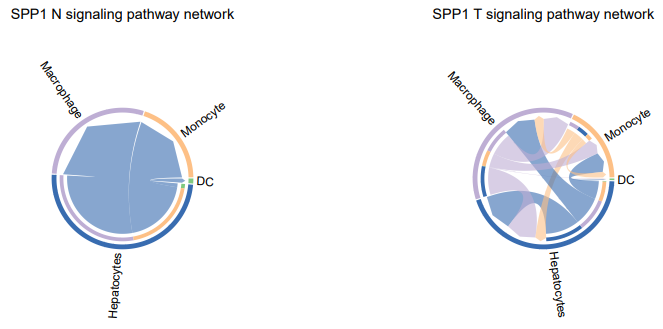

In [ ]:
##Chord L-R pairs
par(mfrow = c(1, 2), xpd=TRUE)
# compare all the interactions sending from Inflam.FIB to DC cells
for (i in 1:length(object.list)) {
  netVisual_chord_gene(object.list[[i]], 
                       sources.use = c(3,4), 
                       color.use =cols, 
                       targets.use = c(2), 
                       show.legend = T,
                       lab.cex = 0.5, title.name = paste0("Signaling from Inflam.FIB - ", names(object.list)[i]))
}

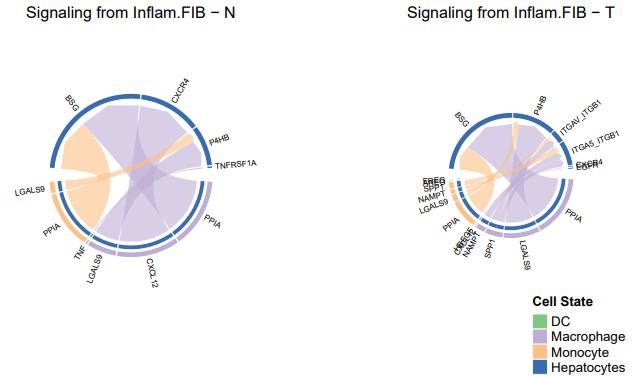

In [ ]:
##Compare the signaling gene expression
cellchat@meta$datasets = factor(cellchat@meta$datasets, levels = c("N", "T")) # set factor level
plotGeneExpression(cellchat, signaling = "SPP1", 
                   split.by = "datasets", 
                   colors.ggplot = T, 
                   type = "violin",
                   color.use =c('#386cb0','#fdc086'))

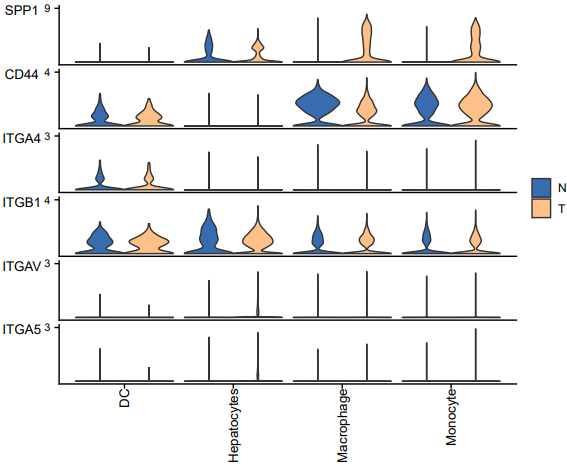

In [ ]:
save(cellchat,file = 'cellchat_merge.rdata')